<a href="https://colab.research.google.com/github/etschgi1/HPC/blob/main/HPC_CUDA_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HPC Cuda Lab

1. Navigate to the "File" menu and select "Save a copy in Drive". This step is crucial to prevent the loss of your work, as it will not be saved automatically.
2. Modify your runtime settings to Nvidia T4, as illustrated in the screenshot provided below.

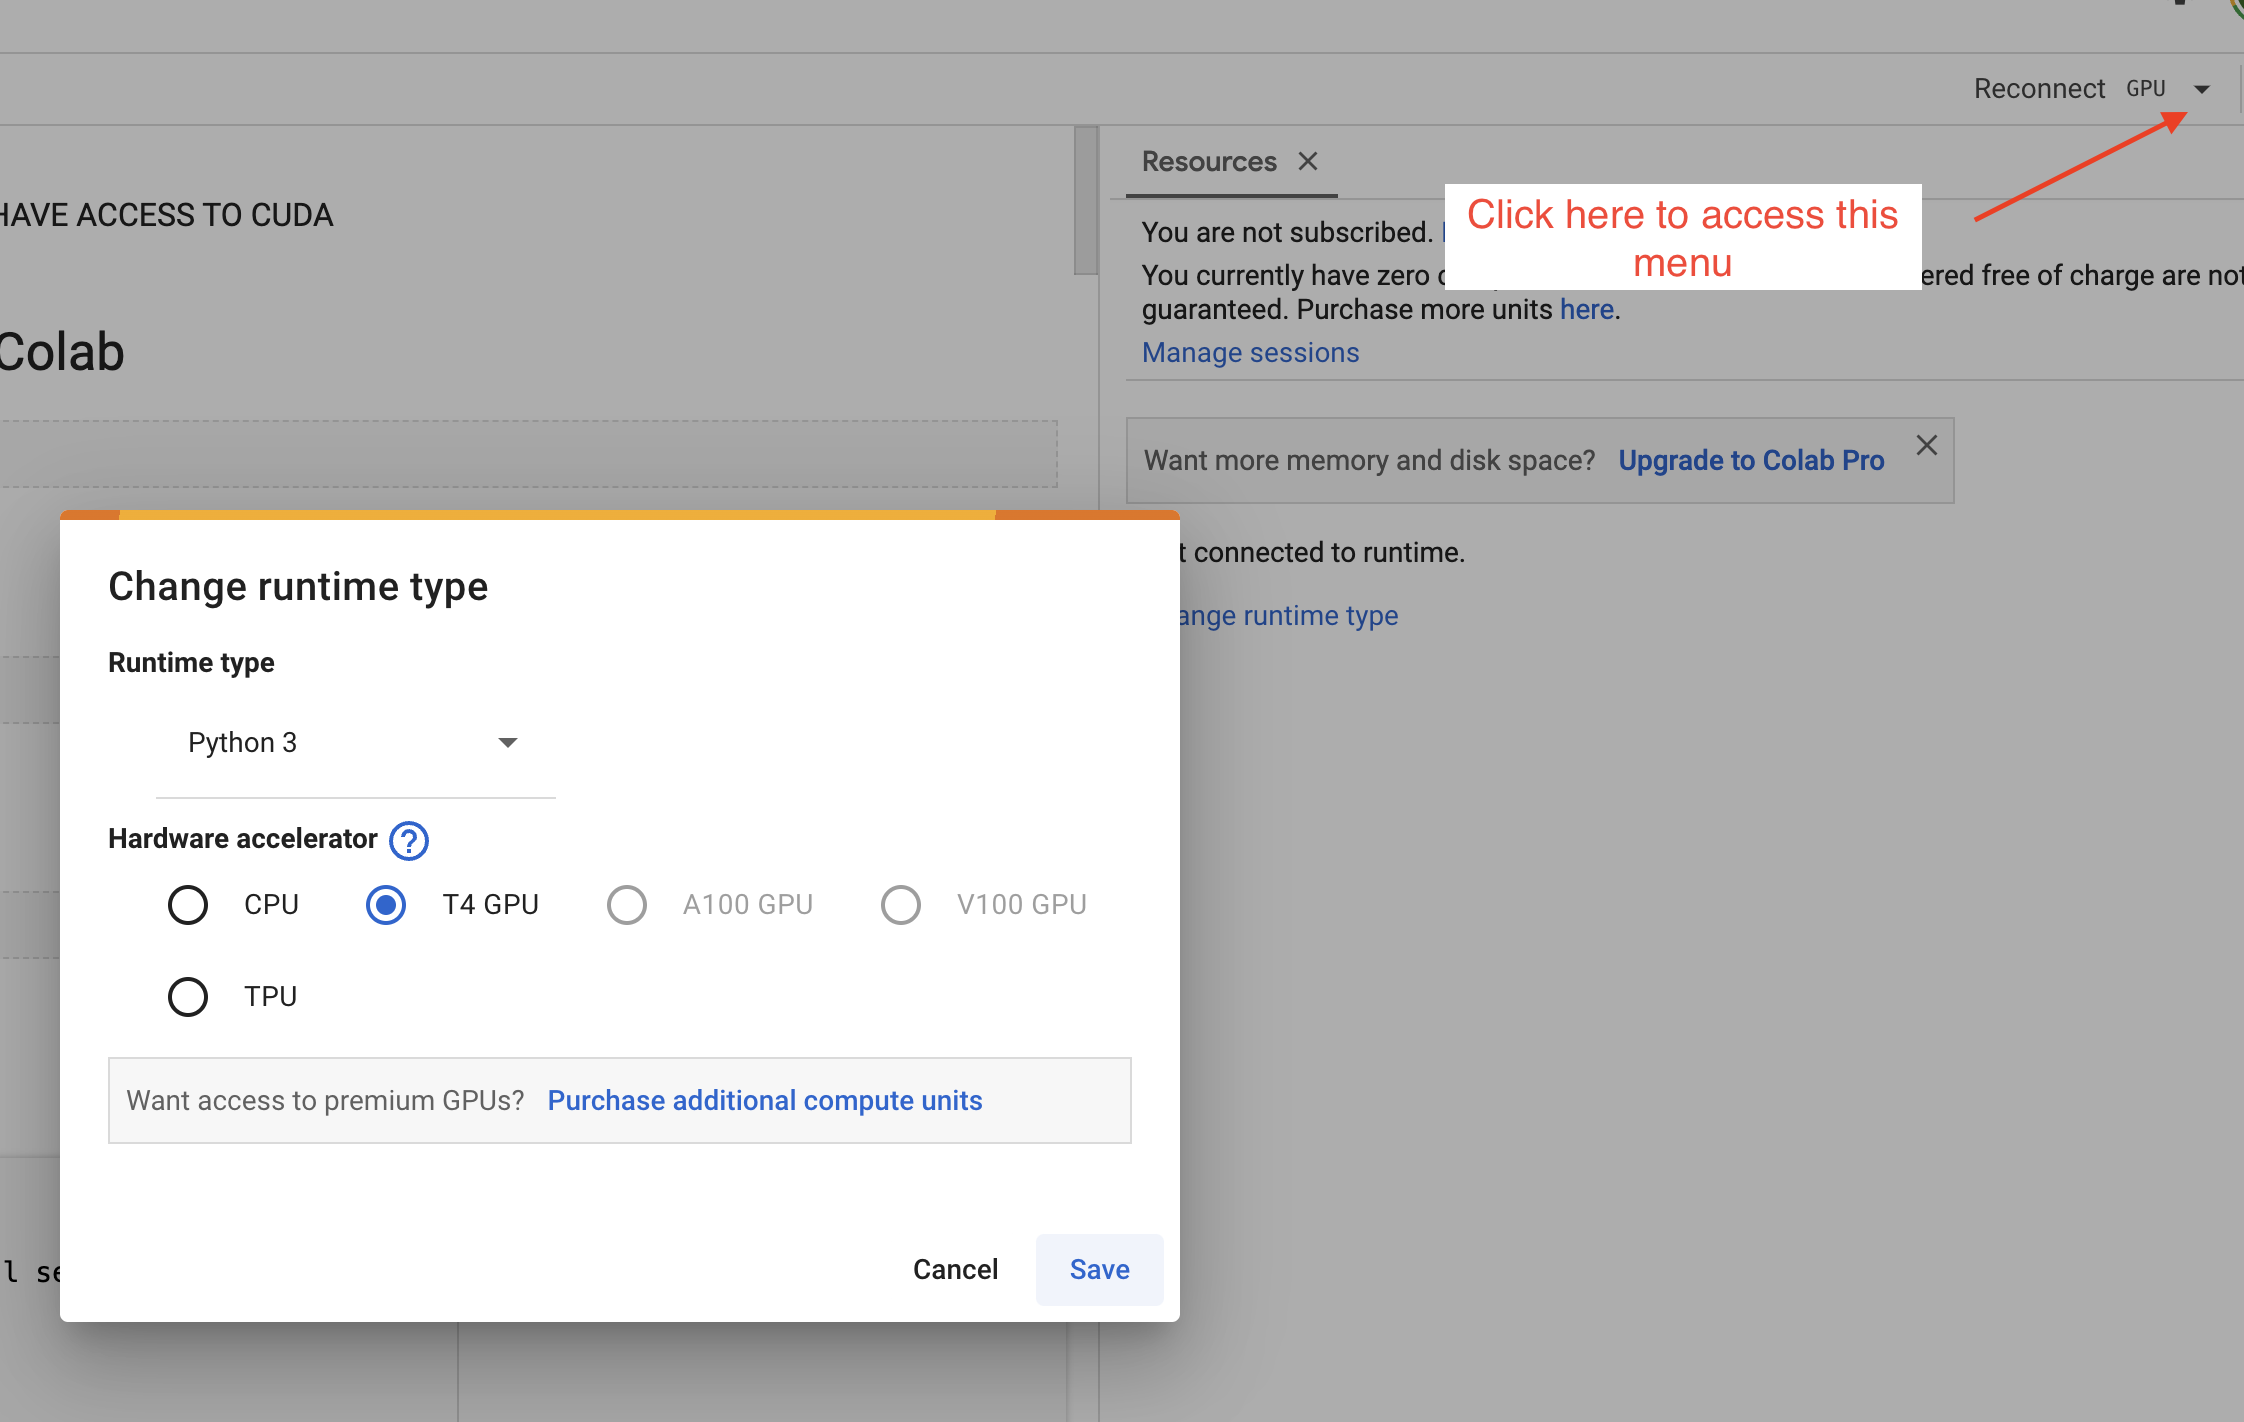

## Setup the cuda environment on Google Colab

In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git


  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-66kv7rdx
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-66kv7rdx
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10742 sha256=fdb30b442a03a2b978d94f242f4f3839c3b517111d4c5bcc31496f40b5aacbba
  Stored in directory: /tmp/pip-ephem-wheel-cache-72gabpal/wheels/ef/1d/c6/f7e47f1aa1bc9d05c4120d94f90a79cf28603ef343b0dd43ff
Successfully built nvcc4jupyter


In [ ]:
%load_ext nvcc4jupyter


Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp7u952b4g".


In [ ]:
!which nvcc

/usr/local/cuda/bin/nvcc


## Hello world example

In [ ]:
%%cuda
#include <iostream>
using namespace std;

int main() {
  cout << "Goodbye, World!" << std::endl;
  return 0;
}

Goodbye, World!



## Matrix multiplication

In [ ]:
%%cuda
// parallel HelloWorld using GPUs
// Simple starting example for CUDA program : this only works on arch 2 or higher
// Cong Xiao and Senlei Wang, Modified on Sep 2018

#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

#define N_THRDS    4 // Nr of threads in a block (blockDim)
#define N_BLKS    4 // Nr of blocks in a kernel (gridDim)

void checkCudaError(const char *error)
{
   if (cudaGetLastError() != cudaSuccess)
   {
      fprintf (stderr, "Cuda : %s\n",error);
      exit(EXIT_FAILURE);
   }
}

void checkCardVersion()
{
   cudaDeviceProp prop;

   cudaGetDeviceProperties(&prop, 0);
   checkCudaError("cudaGetDeviceProperties failed");

   fprintf(stderr,"This GPU has major architecture %d, minor %d \n",prop.major,prop.minor);
   if(prop.major < 2)
   {
      fprintf(stderr,"Need compute capability 2 or higher.\n");
      exit(1);
   }
}

__global__ void HelloworldOnGPU(void)
{
   int myid = (blockIdx.x * blockDim.x) + threadIdx.x;
   // Each thread simply  prints it's own string :
   printf( "Hello World, I am thread %d in block with index %d, my thread index is %d \n",
	   myid, blockIdx.x, threadIdx.x);
}

int main(void)
{
   checkCardVersion();

   HelloworldOnGPU <<< N_BLKS, N_THRDS >>> ();
   cudaDeviceSynchronize(); // without using synchronization, output won't be shown

   return 0;
}

This GPU has major architecture 7, minor 5 
Hello World, I am thread 4 in block with index 1, my thread index is 0 
Hello World, I am thread 5 in block with index 1, my thread index is 1 
Hello World, I am thread 6 in block with index 1, my thread index is 2 
Hello World, I am thread 7 in block with index 1, my thread index is 3 
Hello World, I am thread 12 in block with index 3, my thread index is 0 
Hello World, I am thread 13 in block with index 3, my thread index is 1 
Hello World, I am thread 14 in block with index 3, my thread index is 2 
Hello World, I am thread 15 in block with index 3, my thread index is 3 
Hello World, I am thread 8 in block with index 2, my thread index is 0 
Hello World, I am thread 9 in block with index 2, my thread index is 1 
Hello World, I am thread 10 in block with index 2, my thread index is 2 
Hello World, I am thread 11 in block with index 2, my thread index is 3 
Hello World, I am thread 0 in block with index 0, my thread index is 0 
Hello World, I

## Power methods

In [ ]:
%%cuda

// the subroutine for GPU code can be found in several separated text file from the Brightspace.
// You can add these subroutines to this main code.
////////////////////////////////////////////


#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include "cuda.h"


const int BLOCK_SIZE =32;  // number of threads per block

// Input Array Variables
float* h_MatA = NULL;
float* d_MatA = NULL;

// Output Array
float* h_VecV = NULL;
float* d_VecV = NULL;
float* h_VecW = NULL;
float* d_VecW = NULL;
float* h_NormW = NULL;
float* d_NormW = NULL;

// Variables to change
int GlobalSize = 5000;         // this is the dimension of the matrix, GlobalSize*GlobalSize
int BlockSize = 32;            // number of threads in each block
const float EPS = 0.000005;    // tolerence of the error
int max_iteration = 100;       // the maximum iteration steps


// Functions
void Cleanup(void);
void InitOne(float*, int);
void UploadArray(float*, int);
float CPUReduce(float*, int);
void  Arguments(int, char**);
void checkCardVersion(void);
void ParseArguments(int, char**);

// Kernels
__global__ void Av_Product(float* g_MatA, float* g_VecV, float* g_VecW, int N);
__global__ void FindNormW(float* g_VecW, float * g_NormW, int N);
__global__ void NormalizeW(float *g_VecW, float *d_NormW, float *g_VecV, int N);
__global__ void ComputeLamda( float* g_VecV,float* g_VecW, float * g_Lamda,int N);


void CPU_AvProduct()
{
	int N = GlobalSize;
	int matIndex =0;
    for(int i=0;i<N;i++)
	{
		h_VecW[i] = 0;
		for(int j=0;j<N;j++)
		{
			matIndex = i*N + j;
			h_VecW[i] += h_MatA[matIndex] * h_VecV[j];

		}
	}
}

void CPU_NormalizeW()
{
	int N = GlobalSize;
	float normW=0;
	for(int i=0;i<N;i++)
		normW += h_VecW[i] * h_VecW[i];

	normW = sqrt(normW);
	for(int i=0;i<N;i++)
		h_VecV[i] = h_VecW[i]/normW;
}

float CPU_ComputeLamda()
{
	int N = GlobalSize;
	float lamda =0;
	for(int i=0;i<N;i++)
		lamda += h_VecV[i] * h_VecW[i];

	return lamda;
}

void RunCPUPowerMethod()
{
	printf("*************************************\n");
	float oldLamda =0;
	float lamda=0;

	//AvProduct
	CPU_AvProduct();

	//power loop
	for (int i=0;i<max_iteration;i++)
	{
		CPU_NormalizeW();
		CPU_AvProduct();
		lamda= CPU_ComputeLamda();
		printf("CPU lamda at %d: %f \n", i, lamda);
		// If residual is lass than epsilon break
		if(abs(oldLamda - lamda) < EPS)
			break;
		oldLamda = lamda;

	}
	printf("*************************************\n");

}

void ParseArguments(int argc, char** argv) {
    // If you want to parse some arguments
}

// Host code
int main(int argc, char** argv)
{

    struct timespec t_start,t_end;
    double runtime;
    ParseArguments(argc, argv);

    int N = GlobalSize;
    printf("Matrix size %d X %d \n", N, N);
    size_t vec_size = N * sizeof(float);
    size_t mat_size = N * N * sizeof(float);
    size_t norm_size = sizeof(float);

    // Allocate normalized value in host memory
    h_NormW = (float*)malloc(norm_size);
    // Allocate input matrix in host memory
    h_MatA = (float*)malloc(mat_size);
    // Allocate initial vector V in host memory
    h_VecV = (float*)malloc(vec_size);
    // Allocate W vector for computations
    h_VecW = (float*)malloc(vec_size);


    // Initialize input matrix
    UploadArray(h_MatA, N);
    InitOne(h_VecV,N);

    printf("Power method in CPU starts\n");
    clock_gettime(CLOCK_REALTIME,&t_start);
    RunCPUPowerMethod();   // the lamda is already solved here
    clock_gettime(CLOCK_REALTIME,&t_end);
    runtime = (t_end.tv_sec - t_start.tv_sec) + 1e-9*(t_end.tv_nsec - t_start.tv_nsec);
    printf("CPU: run time = %f secs.\n",runtime);
    printf("Power method in CPU is finished\n");


    /////////////////////////////////////////////////
    // This is the starting points of GPU
    printf("Power method in GPU starts\n");
    checkCardVersion();

    // Initialize input matrix
    InitOne(h_VecV,N);

    clock_gettime(CLOCK_REALTIME,&t_start);  // Here I start to count

    // Set the kernel arguments
    int threadsPerBlock = BlockSize;
    int sharedMemSize = threadsPerBlock * threadsPerBlock * sizeof(float); // in per block, the memory is shared
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // Allocate matrix and vectors in device memory
    cudaMalloc((void**)&d_MatA, mat_size);
    cudaMalloc((void**)&d_VecV, vec_size);
    cudaMalloc((void**)&d_VecW, vec_size); // This vector is only used by the device
    cudaMalloc((void**)&d_NormW, norm_size);

    //Copy from host memory to device memory
    cudaMemcpy(d_MatA, h_MatA, mat_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_VecV, h_VecV, vec_size, cudaMemcpyHostToDevice);
	// cutilCheckError(cutStopTimer(timer_mem));

   //Power method loops
    float OldLamda =0;

    Av_Product<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_MatA, d_VecV, d_VecW, N);
    cudaDeviceSynchronize(); //Needed, kind of barrier to sychronize all threads


    // This part is the main code of the iteration process for the Power Method in GPU.
    // Please finish this part based on the given code. Do not forget the command line
    // cudaDeviceSynchronize() after callig the function every time in CUDA to synchoronize the threads

    ////////////////////////////////////////////
    //   ///      //        //            //          //            //        //
    //                                                                        //
    //                                                                        //
    //                                                                        //
    //                                                                        //
    //                                                                        //
    //                                                                        //
    //                                                                        //
    //  ///   //    ///     //    //      //      //        //       //   //  //



    clock_gettime(CLOCK_REALTIME,&t_end);
    runtime = (t_end.tv_sec - t_start.tv_sec) + 1e-9*(t_end.tv_nsec - t_start.tv_nsec);
    printf("GPU: run time = %f secs.\n",runtime);
    // printf("Overall CPU Execution Time: %f (ms) \n", cutGetTimerValue(timer_CPU));

    Cleanup();
}

void Cleanup(void)
{
    // Free device memory
    if (d_MatA)
        cudaFree(d_MatA);
    if (d_VecV)
        cudaFree(d_VecV);
    if (d_VecW)
        cudaFree(d_VecW);
	  if (d_NormW)
		    cudaFree(d_NormW);

    // Free host memory
    if (h_MatA)
        free(h_MatA);
    if (h_VecV)
        free(h_VecV);
    if (h_VecW)
        free(h_VecW);
    if (h_NormW)
        free(h_NormW);

    exit(0);
}

// Allocates an array with zero value.
void InitOne(float* data, int n)
{
    for (int i = 0; i < n; i++)
        data[i] = 0;
	data[0]=1;
}

void UploadArray(float* data, int n)
{
   int total = n*n;
   int value=1;
    for (int i = 0; i < total; i++)
    {
    	data[i] = (int) (rand() % (int)(101));//1;//value;
	    value ++; if(value>n) value =1;
      // data[i] = 1;
    }
}

// Obtain program arguments
void Arguments(int argc, char** argv)
{
    for (int i = 0; i < argc; ++i)
    {
        if (strcmp(argv[i], "--size") == 0 || strcmp(argv[i], "-size") == 0)
        {
            GlobalSize = atoi(argv[i+1]);
		    i = i + 1;
        }
        if (strcmp(argv[i], "--max_iteration") == 0 || strcmp(argv[i], "-max_iteration") == 0)
        {
            max_iteration = atoi(argv[i+1]);
		    i = i + 1;
        }
    }
}


void checkCardVersion()
{
   cudaDeviceProp prop;

   cudaGetDeviceProperties(&prop, 0);

   printf("This GPU has major architecture %d, minor %d \n",prop.major,prop.minor);
   if(prop.major < 2)
   {
      fprintf(stderr,"Need compute capability 2 or higher.\n");
      exit(1);
   }
}

//   _    _ _______ _____ _      _____ _________     __     __  __ ______ _______ _    _  ____  _____   _____
//  | |  | |__   __|_   _| |    |_   _|__   __\ \   / /    |  \/  |  ____|__   __| |  | |/ __ \|  __ \ / ____|
//  | |  | |  | |    | | | |      | |    | |   \ \_/ /     | \  / | |__     | |  | |__| | |  | | |  | | (___
//  | |  | |  | |    | | | |      | |    | |    \   /      | |\/| |  __|    | |  |  __  | |  | | |  | |\___ \
//  | |__| |  | |   _| |_| |____ _| |_   | |     | |       | |  | | |____   | |  | |  | | |__| | |__| |____) |
//   \____/   |_|  |_____|______|_____|  |_|     |_|       |_|  |_|______|  |_|  |_|  |_|\____/|_____/|_____/


// This is a list of utility methods that should you use in your code

/*****************************************************************************
This function finds the product of Matrix A and vector V
*****************************************************************************/

// ****************************************************************************************************************************************************/
// parallelization method for the Matrix-vector multiplication as follows:

// each thread handle a multiplication of each row of Matrix A and vector V;

// The share memory is limited for a block, instead of reading an entire row of matrix A or vector V from global memory to share memory,
// a square submatrix of A is shared by a block, the size of square submatrix is BLOCK_SIZE*BLOCK_SIZE; Thus, a for-loop is used to
// handle a multiplication of each row of Matrix A and vector V step by step. In eacg step, two subvectors with size BLOCK_SIZE is multiplied.
//*****************************************************************************************************************************************************/


__global__ void Av_Product(float* g_MatA, float* g_VecV, float* g_VecW, int N)
{
    // Block index
    int bx = blockIdx.x;

    // Thread index
    int tx = threadIdx.x;

    int aBegin = N * BLOCK_SIZE * bx;

    int aEnd   = aBegin + N - 1;
    int step  = BLOCK_SIZE;

    int bBegin = 0;//BLOCK_SIZE * bx;
    int bIndex=0;
    int aIndex =0;
    float Csub = 0;

    for (int a = aBegin, b = bBegin;
         a <= aEnd;
         a += step, b += step)
    {

        __shared__ float As[BLOCK_SIZE*BLOCK_SIZE];

        __shared__ float bs[BLOCK_SIZE];


        for (int aa = 0; aa < BLOCK_SIZE;aa+= 1)
        {
            aIndex = a+tx+aa*N;
            if( aIndex < N*N)
        	    As[tx+aa*BLOCK_SIZE] = g_MatA[aIndex];
		        else
        	    As[tx+aa*BLOCK_SIZE] = 0;
        }

        bIndex = b+tx;
   	    if(bIndex<N)
		      bs[tx] = g_VecV[bIndex];
	      else
		      bs[tx] = 0;

        __syncthreads();

        for (int k = 0; k < BLOCK_SIZE; ++k)
        {
            Csub += As[k+tx*BLOCK_SIZE] * bs[k];
        }//}
        __syncthreads();
    }

    g_VecW[ BLOCK_SIZE * bx + tx] = Csub;
}

/****************************************************
Normalizes vector W : W/norm(W)
****************************************************/
__global__ void FindNormW(float* g_VecW, float * g_NormW, int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sdata[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  // For thread ids greater than data space
  if (globalid < N) {
     sdata[tid] =  g_VecW[globalid];
  }
  else {
     sdata[tid] = 0;  // Case of extra threads above N
  }

  // each thread loads one element from global to shared mem
  __syncthreads();

  sdata[tid] = sdata[tid] * sdata[tid];
  __syncthreads();

  // do reduction in shared mem
  for (unsigned int s=blockDim.x / 2; s > 0; s = s >> 1) {
     if (tid < s) {
         sdata[tid] = sdata[tid] + sdata[tid+ s];
     }
     __syncthreads();
  }
   // atomic operations:
  if (tid == 0) atomicAdd(g_NormW,sdata[0]);
}

__global__ void NormalizeW(float* g_VecW, float* g_NormW, float* g_VecV, int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sNormData[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  if(tid==0) sNormData[0] =  g_NormW[0];
  __syncthreads();

  // For thread ids greater than data space
  if (globalid < N) {
     g_VecV[globalid] = g_VecW[globalid]/sNormData[0];
  }

}

__global__ void ComputeLamda( float* g_VecV, float* g_VecW, float * g_Lamda,int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sdataVW[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  // For thread ids greater than data space
  if (globalid < N) {
     sdataVW[tid] =  g_VecV[globalid] * g_VecW[globalid];
  }
  else {
     sdataVW[tid] = 0;  // Case of extra threads above N
  }

  // each thread loads one element from global to shared mem
  __syncthreads();

  // do reduction in shared mem
  for (unsigned int s=blockDim.x / 2; s > 0; s = s >> 1) {
     if (tid < s) {
         sdataVW[tid] = sdataVW[tid] + sdataVW[tid+ s];
     }
     __syncthreads();
  }
   // atomic operations:
  if (tid == 0) atomicAdd(g_Lamda,sdataVW[0]);
}

Matrix size 5000 X 5000 
Power method in CPU starts
*************************************
CPU lamda at 0: 185252.250000 
CPU lamda at 1: 249989.812500 
CPU lamda at 2: 249995.421875 
CPU lamda at 3: 249995.781250 
CPU lamda at 4: 249995.687500 
CPU lamda at 5: 249995.781250 
CPU lamda at 6: 249995.828125 
CPU lamda at 7: 249995.750000 
CPU lamda at 8: 249995.765625 
CPU lamda at 9: 249995.812500 
CPU lamda at 10: 249995.750000 
CPU lamda at 11: 249995.812500 
CPU lamda at 12: 249995.812500 
*************************************
CPU: run time = 2.024792 secs.
Power method in CPU is finished
Power method in GPU starts
This GPU has major architecture 7, minor 5 
GPU: run time = 0.298567 secs.



# Parallel Implementation of CUDA Code

TODO: Finish missing part of power_gpu.cu

UploadArray, InitOne

Recode: CPU_AcPoduct, CPU_NormalizedW and CPU_ComputeLambda

(Here, four subroutines, GPU_AvPoduct, GPU_FindNormW, GPU_NormalizedW, and GPU_ComputeLamda, are provided to implement the Power Method in GPU)

In [ ]:
%%cuda

// the subroutine for GPU code can be found in several separated text file from the Brightspace.
// You can add these subroutines to this main code.
////////////////////////////////////////////


#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>
#include "cuda.h"
#include <stdarg.h> // For variable argument handling
#include <assert.h>


const int BLOCK_SIZE =32;  // number of threads per block
int PRINTLEVEL = 1;
bool GLOBAL_MEM = true;
bool WITHOUT_MEMCPY = false;

// Input Array Variables
float* h_MatA = NULL;
float* d_MatA = NULL;

// Output Array
float* h_VecV = NULL;
float* d_VecV = NULL;
float* h_VecW = NULL;
float* d_VecW = NULL;
float* h_NormW = NULL;
float* d_NormW = NULL;

// Variables to change
int GlobalSize = 5000;         // this is the dimension of the matrix, GlobalSize*GlobalSize
int BlockSize = 32;            // number of threads in each block
const float EPS = 0.000005;    // tolerence of the error
int max_iteration = 100;       // the maximum iteration steps


// Functions
void Cleanup(void);
void InitOne(float*, int);
void UploadArray(float*, int);
float CPUReduce(float*, int);
void  Arguments(int, char**);
void checkCardVersion(void);
void CleanGPU();

// Kernels
__global__ void Av_Product(float* g_MatA, float* g_VecV, float* g_VecW, int N);
__global__ void Av_ProductGlobal(float* g_MatA, float* g_VecV, float* g_VecW, int N);
__global__ void FindNormW(float* g_VecW, float * g_NormW, int N);
__global__ void NormalizeW(float* g_VecW, float* g_NormW, float* g_VecV, int N);
__global__ void ComputeLamda( float* g_VecV,float* g_VecW, float * g_Lamda,int N);
__global__ void Av_Product_1D(const float* A, const float* v, float* w, int N);

//dummy for args!
void ParseArguments(int argc, char** argv) {
    // If you want to parse some arguments
}

void CPU_AvProduct()
{
	int N = GlobalSize;
	int matIndex =0;
    for(int i=0;i<N;i++)
	{
		h_VecW[i] = 0;
		for(int j=0;j<N;j++)
		{
			matIndex = i*N + j;
			h_VecW[i] += h_MatA[matIndex] * h_VecV[j];

		}
	}
}

void CPU_NormalizeW()
{
	int N = GlobalSize;
	float normW=0;
	for(int i=0;i<N;i++)
		normW += h_VecW[i] * h_VecW[i];

	normW = sqrt(normW);
	for(int i=0;i<N;i++)
		h_VecV[i] = h_VecW[i]/normW;
}

float CPU_ComputeLamda()
{
	int N = GlobalSize;
	float lamda =0;
	for(int i=0;i<N;i++)
		lamda += h_VecV[i] * h_VecW[i];

	return lamda;
}

void RunCPUPowerMethod()
{
	printf("*************************************\n");
	float oldLamda =0;
	float lamda=0;

	//AvProduct
	CPU_AvProduct();

	//power loop
	for (int i=0;i<max_iteration;i++)
	{
		CPU_NormalizeW();
		CPU_AvProduct();
		lamda= CPU_ComputeLamda();
		printf("CPU lamda at %d: %f \n", i, lamda);
		// If residual is lass than epsilon break
		if(abs(oldLamda - lamda) < EPS)
			break;
		oldLamda = lamda;

	}
	printf("*************************************\n");

}



void printfD(int threshold, const char* format, ...) {
    if (PRINTLEVEL >= threshold) {
        va_list args;
        va_start(args, format);
        vprintf(format, args); // Use vprintf to handle the variable arguments
        va_end(args);
    }
}

typedef struct {
    struct timespec start_time;
    struct timespec end_time;
    double elapsed; // Cumulative elapsed time
    int running;    // Flag to track if the timer is running
} Timer;

// Function to initialize the timer
void timer_init(Timer* timer) {
    timer->elapsed = 0.0;
    timer->running = 0;
}

// Function to start the timer
void timer_start(Timer* timer) {
    if (!timer->running) {
        clock_gettime(CLOCK_REALTIME, &timer->start_time);
        timer->running = 1;
    }
}

// Function to stop the timer
void timer_stop(Timer* timer) {
    if (timer->running) {
        clock_gettime(CLOCK_REALTIME, &timer->end_time);
        double start_sec = timer->start_time.tv_sec + timer->start_time.tv_nsec / 1e9;
        double end_sec = timer->end_time.tv_sec + timer->end_time.tv_nsec / 1e9;
        timer->elapsed += end_sec - start_sec;
        timer->running = 0;
    }
}

// Function to get the total elapsed time in seconds
double timer_get_elapsed(Timer* timer) {
    if (timer->running) {
        struct timespec now;
        clock_gettime(CLOCK_REALTIME, &now);
        double start_sec = timer->start_time.tv_sec + timer->start_time.tv_nsec / 1e9;
        double now_sec = now.tv_sec + now.tv_nsec / 1e9;
        return timer->elapsed + (now_sec - start_sec);
    }
    return timer->elapsed;
}


double RunGPUPowerMethod(int N){
    double runtime;
    // timers
    Timer total_time_GPU;
    Timer time_GPU_mem;
    Timer time_GPU_kernels;

    timer_init(&total_time_GPU);
    timer_init(&time_GPU_mem);
    timer_init(&time_GPU_kernels);

    printfD(0, "Power method in GPU starts\n");
    checkCardVersion();

    size_t vec_size = N * sizeof(float);
    size_t mat_size = N * N * sizeof(float);
    size_t norm_size = sizeof(float);


    timer_start(&total_time_GPU);
    // Set the kernel arguments
    int threadsPerBlock = BlockSize;
    int sharedMemSize = threadsPerBlock * threadsPerBlock * sizeof(float); // in per block, the memory is shared
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    timer_start(&total_time_GPU);
    // Allocate matrix and vectors in device memory
    cudaMalloc((void**)&d_MatA, mat_size);
    cudaMalloc((void**)&d_VecV, vec_size);
    cudaMalloc((void**)&d_VecW, vec_size); // This vector is only used by the device
    cudaMalloc((void**)&d_NormW, norm_size);


    //Copy from host memory to device memory
    timer_start(&time_GPU_mem);
    cudaMemcpy(d_MatA, h_MatA, mat_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_VecV, h_VecV, vec_size, cudaMemcpyHostToDevice);
    timer_stop(&time_GPU_mem);

   //Power method loops
    float OldLamda = 0;
    float Lambda = 0;
    h_NormW = 0;

    if(GLOBAL_MEM == true){
      Av_ProductGlobal<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_MatA, d_VecV, d_VecW, N); //first w
    }
    else{
      Av_Product<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_MatA, d_VecV, d_VecW, N); //first w
    }
    cudaThreadSynchronize(); //Needed, kind of barrier to sychronize all threads

    // This part is the main code of the iteration process for the Power Method in GPU.
    // Please finish this part based on the given code. Do not forget the command line
    // cudaThreadSynchronize() after callig the function every time in CUDA to synchoronize the threads
    ////////////////////////////////////////////
    for(int i=0; i < max_iteration; ++i){
      timer_start(&time_GPU_mem);
      cudaMemcpy(d_NormW, h_NormW, norm_size, cudaMemcpyHostToDevice);
      timer_stop(&time_GPU_mem);
      cudaThreadSynchronize();

      // Get norm
      cudaMemset(d_NormW, 0, norm_size);
      FindNormW<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_VecW, d_NormW, N);
      cudaThreadSynchronize(); //Needed, kind of barrier to sychronize all threads

      // Normalize vec
      NormalizeW<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_VecW, d_NormW, d_VecV, N);
      cudaThreadSynchronize(); //Needed, kind of barrier to sychronize all threads

      // get new w vec
      if(GLOBAL_MEM == true){
        Av_ProductGlobal<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_MatA, d_VecV, d_VecW, N); //first w
      }
      else{
        Av_Product<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_MatA, d_VecV, d_VecW, N); //first w
      }
      cudaThreadSynchronize(); //Needed, kind of barrier to sychronize all threads

      // get eigenvalue
      cudaMemset(d_NormW, 0, norm_size);
      ComputeLamda<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(d_VecV, d_VecW, d_NormW, N);
      cudaThreadSynchronize(); //Needed, kind of barrier to sychronize all threads
      timer_start(&time_GPU_mem);
      cudaMemcpy(&Lambda, d_NormW, sizeof(float), cudaMemcpyDeviceToHost);
      timer_stop(&time_GPU_mem);

      printfD(2,"GPU lamda at %d: %f \n", i, Lambda);
      // If residual is lass than epsilon break
      if(fabs(OldLamda - Lambda) < EPS){
        printfD(1,"Early exit at %d\n", i);
        break;
      }
      OldLamda = Lambda;
    }


    timer_stop(&total_time_GPU);
    runtime = timer_get_elapsed(&total_time_GPU);
    double memtime = timer_get_elapsed(&time_GPU_mem);
    printf("Lambda: %f\n", Lambda);
    printfD(1,"GPU: run time = %f secs.\n",runtime);
    if(WITHOUT_MEMCPY == true){
        runtime -= memtime;
        assert (runtime > 0);
    }
    return runtime;
}

// Host code
int main(int argc, char** argv)
{
    struct timespec t_start,t_end;
    double runtime;
    ParseArguments(argc, argv);

    int N = GlobalSize;
    printf("Matrix size %d X %d \n", N, N);
    size_t vec_size = N * sizeof(float);
    size_t mat_size = N * N * sizeof(float);
    size_t norm_size = sizeof(float);

    // Allocate normalized value in host memory
    h_NormW = (float*)malloc(norm_size);
    // Allocate input matrix in host memory
    h_MatA = (float*)malloc(mat_size);
    // Allocate initial vector V in host memory
    h_VecV = (float*)malloc(vec_size);
    // Allocate W vector for computations
    h_VecW = (float*)malloc(vec_size);


    // Initialize input matrix
    UploadArray(h_MatA, N);
    InitOne(h_VecV,N);

    printf("Power method in CPU starts\n");
    clock_gettime(CLOCK_REALTIME,&t_start);
    RunCPUPowerMethod();   // the lamda is already solved here
    clock_gettime(CLOCK_REALTIME,&t_end);
    runtime = (t_end.tv_sec - t_start.tv_sec) + 1e-9*(t_end.tv_nsec - t_start.tv_nsec);
    printf("CPU: run time = %f secs.\n",runtime);
    printf("Power method in CPU is finished\n");


    /////////////////////////////////////////////////
    // This is the starting points of GPU
    // burner run!
    RunGPUPowerMethod(N);
    // Step 1
    printf(">>>Step 1\n");
    GLOBAL_MEM = true;
    for(int i = 0; i < 5; ++i){
      RunGPUPowerMethod(N);
      CleanGPU();
    }
    GLOBAL_MEM = false;
    printf(">>>Step 1 shared mem\n");
    for(int i = 0; i < 5; ++i){
      RunGPUPowerMethod(N);
      CleanGPU();
    }

    // Step 2:
    //PRINTLEVEL = 0;
    //int Ns[] = {5000};
    //for(int i = 0; i < 1; ++i){
    //  N = Ns[i];
    //  double time = RunGPUPowerMethod(N);
    //  printf("%d - GPU: run time = %f secs.\n",N,time);
    //  CleanGPU();
    //}
    /////////////////////////////////////////////////

    Cleanup();
}
void CleanGPU(){
       // Free device memory
    if (d_MatA)
        cudaFree(d_MatA);
    if (d_VecV)
        cudaFree(d_VecV);
    if (d_VecW)
        cudaFree(d_VecW);
	  if (d_NormW)
		    cudaFree(d_NormW);
}

void Cleanup(void)
{
    // Free device memory
    if (d_MatA)
        cudaFree(d_MatA);
    if (d_VecV)
        cudaFree(d_VecV);
    if (d_VecW)
        cudaFree(d_VecW);
	  if (d_NormW)
		    cudaFree(d_NormW);

    // Free host memory
    if (h_MatA)
        free(h_MatA);
    if (h_VecV)
        free(h_VecV);
    if (h_VecW)
        free(h_VecW);
    if (h_NormW)
        free(h_NormW);

    exit(0);
}

// Allocates an array with zero value.
void InitOne(float* data, int n)
{
    for (int i = 0; i < n; i++)
        data[i] = 0;
	data[0]=1;
}

void UploadArray(float* data, int n)
{
   int total = n*n;
   int value=1;
    for (int i = 0; i < total; i++)
    {
    	data[i] = (int) (rand() % (int)(101));//1;//value;
	    value ++; if(value>n) value =1;
      // data[i] = 1;
    }
}

// Obtain program arguments
void Arguments(int argc, char** argv)
{
    for (int i = 0; i < argc; ++i)
    {
        if (strcmp(argv[i], "--size") == 0 || strcmp(argv[i], "-size") == 0)
        {
            GlobalSize = atoi(argv[i+1]);
		    i = i + 1;
        }
        if (strcmp(argv[i], "--max_iteration") == 0 || strcmp(argv[i], "-max_iteration") == 0)
        {
            max_iteration = atoi(argv[i+1]);
		    i = i + 1;
        }
    }
}


void checkCardVersion()
{
   cudaDeviceProp prop;

   cudaGetDeviceProperties(&prop, 0);

   printfD(2, "This GPU has major architecture %d, minor %d \n",prop.major,prop.minor);
   if(prop.major < 2)
   {
      fprintf(stderr,"Need compute capability 2 or higher.\n");
      exit(1);
   }
}

//   _    _ _______ _____ _      _____ _________     __     __  __ ______ _______ _    _  ____  _____   _____
//  | |  | |__   __|_   _| |    |_   _|__   __\ \   / /    |  \/  |  ____|__   __| |  | |/ __ \|  __ \ / ____|
//  | |  | |  | |    | | | |      | |    | |   \ \_/ /     | \  / | |__     | |  | |__| | |  | | |  | | (___
//  | |  | |  | |    | | | |      | |    | |    \   /      | |\/| |  __|    | |  |  __  | |  | | |  | |\___ \
//  | |__| |  | |   _| |_| |____ _| |_   | |     | |       | |  | | |____   | |  | |  | | |__| | |__| |____) |
//   \____/   |_|  |_____|______|_____|  |_|     |_|       |_|  |_|______|  |_|  |_|  |_|\____/|_____/|_____/


// This is a list of utility methods that should you use in your code

/*****************************************************************************
This function finds the product of Matrix A and vector V
*****************************************************************************/

// ****************************************************************************************************************************************************/
// parallelization method for the Matrix-vector multiplication as follows:

// each thread handle a multiplication of each row of Matrix A and vector V;

// The share memory is limited for a block, instead of reading an entire row of matrix A or vector V from global memory to share memory,
// a square submatrix of A is shared by a block, the size of square submatrix is BLOCK_SIZE*BLOCK_SIZE; Thus, a for-loop is used to
// handle a multiplication of each row of Matrix A and vector V step by step. In eacg step, two subvectors with size BLOCK_SIZE is multiplied.
//*****************************************************************************************************************************************************/

__global__ void Av_ProductGlobal(float* g_MatA, float* g_VecV, float* g_VecW, int N)
{
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row >= N) return;

    float sum = 0.0f;
    for (int col = 0; col < N; col++) {
        sum += g_MatA[row * N + col] * g_VecV[col];
    }
    g_VecW[row] = sum;
}
__global__ void Av_Product(float* g_MatA, float* g_VecV, float* g_VecW, int N)
{
    // Block index
    int bx = blockIdx.x;

    // Thread index
    int tx = threadIdx.x;

    int aBegin = N * BLOCK_SIZE * bx;

    int aEnd   = aBegin + N - 1;
    int step  = BLOCK_SIZE;

    int bBegin = 0;//BLOCK_SIZE * bx;
    int bIndex=0;
    int aIndex =0;
    float Csub = 0;

    for (int a = aBegin, b = bBegin;
         a <= aEnd;
         a += step, b += step)
    {

        __shared__ float As[BLOCK_SIZE*BLOCK_SIZE];

        __shared__ float bs[BLOCK_SIZE];


        for (int aa = 0; aa < BLOCK_SIZE;aa+= 1)
        {
            aIndex = a+tx+aa*N;
            if( aIndex < N*N)
        	    As[tx+aa*BLOCK_SIZE] = g_MatA[aIndex];
		        else
        	    As[tx+aa*BLOCK_SIZE] = 0;
        }

        bIndex = b+tx;
   	    if(bIndex<N)
		      bs[tx] = g_VecV[bIndex];
	      else
		      bs[tx] = 0;

        __syncthreads();

        for (int k = 0; k < BLOCK_SIZE; ++k)
        {
            Csub += As[k+tx*BLOCK_SIZE] * bs[k];
        }//}
        __syncthreads();
    }

    g_VecW[ BLOCK_SIZE * bx + tx] = Csub;
}

/****************************************************
Normalizes vector W : W/norm(W)
****************************************************/
__global__ void FindNormW(float* g_VecW, float * g_NormW, int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sdata[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  // For thread ids greater than data space
  if (globalid < N) {
     sdata[tid] =  g_VecW[globalid];
  }
  else {
     sdata[tid] = 0;  // Case of extra threads above N
  }

  // each thread loads one element from global to shared mem
  __syncthreads();

  sdata[tid] = sdata[tid] * sdata[tid];
  __syncthreads();

  // do reduction in shared mem
  for (unsigned int s=blockDim.x / 2; s > 0; s = s >> 1) {
     if (tid < s) {
         sdata[tid] = sdata[tid] + sdata[tid+ s];
     }
     __syncthreads();
  }
   // atomic operations:
  if (tid == 0) atomicAdd(g_NormW,sdata[0]);
}

__global__ void NormalizeW(float* g_VecW, float* g_NormW, float* g_VecV, int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sNormData[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  if(tid==0) sNormData[0] =  sqrt(g_NormW[0]);
  __syncthreads();

  // For thread ids greater than data space
  if (globalid < N) {
     g_VecV[globalid] = g_VecW[globalid]/sNormData[0];
  }

}

__global__ void ComputeLamda( float* g_VecV, float* g_VecW, float * g_Lamda,int N)
{
  // shared memory size declared at kernel launch
  extern __shared__ float sdataVW[];
  unsigned int tid = threadIdx.x;
  unsigned int globalid = blockIdx.x*blockDim.x + threadIdx.x;

  // For thread ids greater than data space
  if (globalid < N) {
     sdataVW[tid] =  g_VecV[globalid] * g_VecW[globalid];
  }
  else {
     sdataVW[tid] = 0;  // Case of extra threads above N
  }

  // each thread loads one element from global to shared mem
  __syncthreads();

  // do reduction in shared mem
  for (unsigned int s=blockDim.x / 2; s > 0; s = s >> 1) {
     if (tid < s) {
         sdataVW[tid] = sdataVW[tid] + sdataVW[tid+ s];
     }
     __syncthreads();
  }
   // atomic operations:
  if (tid == 0) atomicAdd(g_Lamda,sdataVW[0]);
}


Matrix size 5000 X 5000 
Power method in CPU starts
*************************************
CPU lamda at 0: 185252.250000 
CPU lamda at 1: 249989.812500 
CPU lamda at 2: 249995.421875 
CPU lamda at 3: 249995.781250 
CPU lamda at 4: 249995.687500 
CPU lamda at 5: 249995.781250 
CPU lamda at 6: 249995.828125 
CPU lamda at 7: 249995.750000 
CPU lamda at 8: 249995.765625 
CPU lamda at 9: 249995.812500 
CPU lamda at 10: 249995.750000 
CPU lamda at 11: 249995.812500 
CPU lamda at 12: 249995.812500 
*************************************
CPU: run time = 1.302737 secs.
Power method in CPU is finished
Power method in GPU starts
Early exit at 8
Lambda: 249996.093750
GPU: run time = 0.125977 secs.
>>>Step 1
Power method in GPU starts
Early exit at 13
Lambda: 249996.093750
GPU: run time = 0.043776 secs.
Power method in GPU starts
Early exit at 13
Lambda: 249996.093750
GPU: run time = 0.046394 secs.
Power method in GPU starts
Early exit at 18
Lambda: 249996.062500
GPU: run time = 0.054036 secs.
Power 